In [1]:
import pandas as pd
import torch

from common.result_analysis import *

### 1. Load data ###

In [2]:
congress_to_embedding_dict = torch.load('data/output_data/global_embedding_for_reweighted_edges_dim20_kin2_kout1.pth', weights_only = True)

global_congress_table = pd.read_csv('data/raw_data/all_congress_members.csv')
global_congress_table.loc[:, 'twitter_name'] = global_congress_table['twitter_name'].str.lower()

In [3]:
re_weight_kin2_congress_to_embedding = torch.load('data/output_data/re-weight__kin2/global_embedding_for_reweighted_edges_dim20.pth', weights_only = True)
re_weight_kin3_congress_to_embedding = torch.load('data/output_data/re-weight__kin3/global_embedding_for_reweighted_edges_dim20.pth', weights_only = True)
re_weight_kin5_congress_to_embedding = torch.load('data/output_data/re-weight__kin5/global_embedding_for_reweighted_edges_dim20.pth', weights_only = True)
re_weight_kin10_congress_to_embedding = torch.load('data/output_data/re-weight_kin10/global_embedding_for_reweighted_edges_dim20.pth', weights_only = True)

unweighted_kin2_congress_to_embedding = torch.load('data/output_data/global_embedding_kin2_kout1_dim20.pth', weights_only = True)
unweighted_kin3_congress_to_embedding = torch.load('data/output_data/global_embedding_kin3_kout1_dim20.pth', weights_only = True)
unweighted_kin5_congress_to_embedding = torch.load('data/output_data/global_embedding_kin5_kout1_dim20.pth', weights_only = True)
unweighted_kin10_congress_to_embedding = torch.load('data/output_data/global_embedding_kin10_kout1_dim20.pth', weights_only = True)

k_w_to_congress_to_embedding = {((2, 1), True): re_weight_kin2_congress_to_embedding,
                                    ((3, 1), True): re_weight_kin3_congress_to_embedding,
                                    ((5, 1), True): re_weight_kin5_congress_to_embedding, 
                                    ((10, 1), True): re_weight_kin10_congress_to_embedding,
                                    ((2, 1), False): unweighted_kin2_congress_to_embedding,
                                    ((3, 1), False): unweighted_kin3_congress_to_embedding,
                                    ((5, 1), False): unweighted_kin5_congress_to_embedding,
                                    ((10, 1), False): unweighted_kin10_congress_to_embedding}

In [4]:
k_w_to_congress_to_2pc = {}

for (k_pair, is_re_weighted), congress_to_embedding in k_w_to_congress_to_embedding.items():
    congress_to_2pc = pca_reduction(congress_to_embedding)
    k_w_to_congress_to_2pc[(k_pair, is_re_weighted)] = congress_to_2pc

### 2. PCA reduction, opinion estimation and evaluation ###

81 102


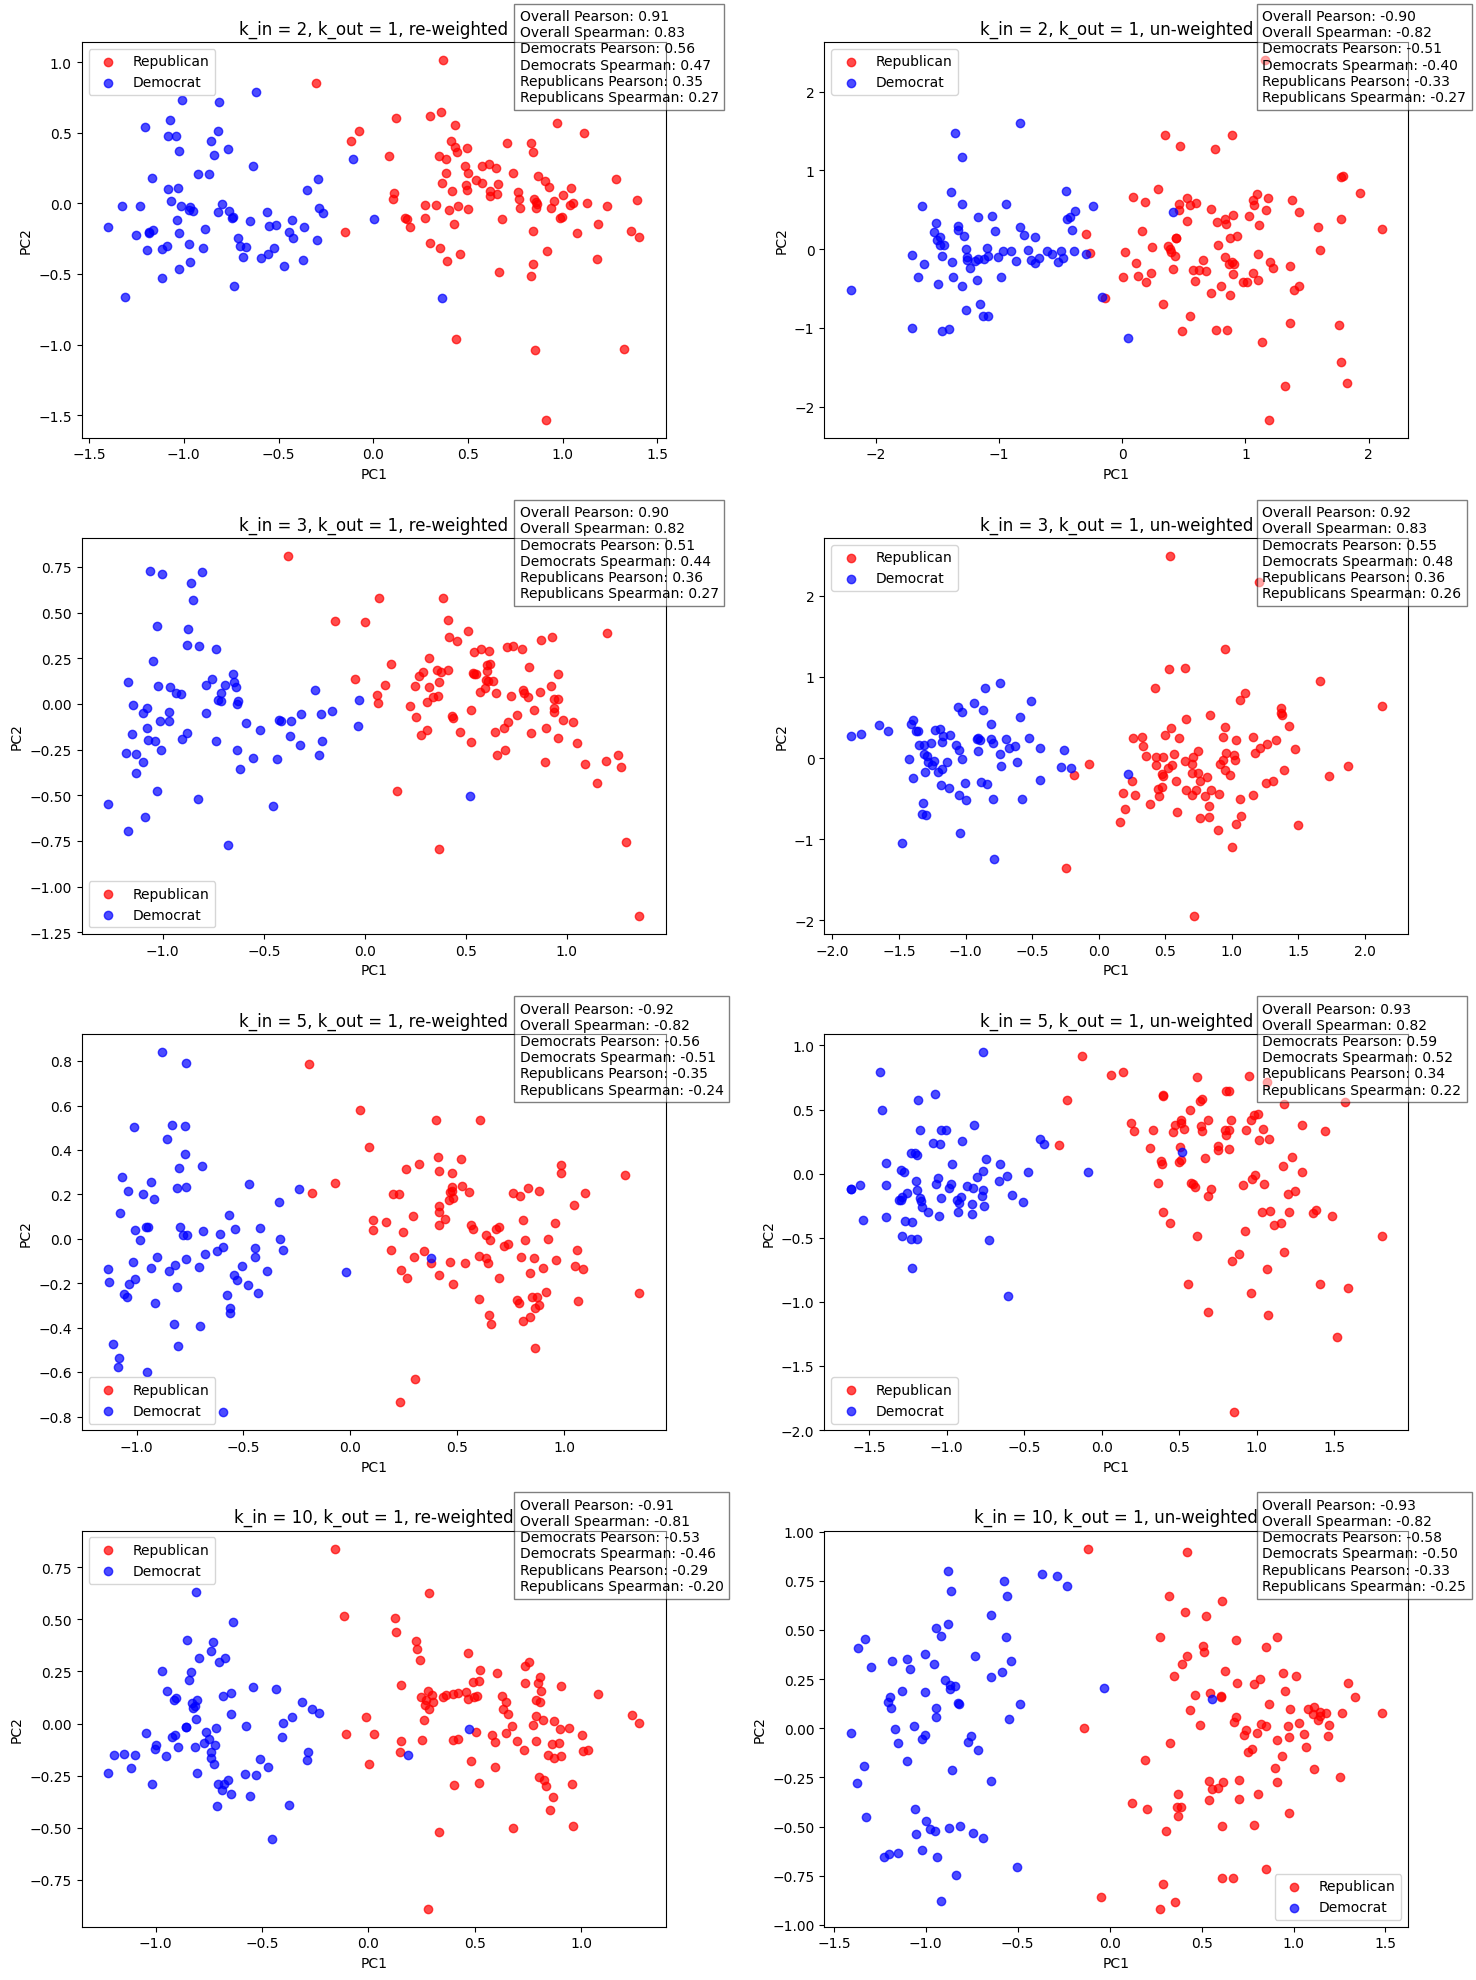

In [5]:
democrats = global_congress_table[global_congress_table['party'] == 'D']
republicans = global_congress_table[global_congress_table['party'] == 'R']

print(len(democrats), len(republicans))

row_num = 4
col_num = 2

fig, axs = plt.subplots(row_num, col_num, figsize=(15, 20))
count = 0

for (k_pair, is_re_weighted), congress_to_2pc in k_w_to_congress_to_2pc.items():
    # Opinion estimation vs DW-NOMINATE
    congress_to_pc1_dw = {}

    for (congress_member, pc) in congress_to_2pc.items():
        dw_value = global_congress_table.loc[global_congress_table['twitter_name'] == congress_member, 'DW-Nominate'].values[0]
        congress_to_pc1_dw[congress_member] = (pc[0], dw_value)
        
    title = 'k_in = ' + str(k_pair[0]) + ', k_out = ' + str(k_pair[1])
    if is_re_weighted:
        title += ', re-weighted'
    else:
        title += ', un-weighted'
    
    row = count % row_num
    col = count // row_num
    
    plot_pc2(democrats, republicans, congress_to_2pc, congress_to_pc1_dw, axs[row][col], title)
    
    count += 1

plt.tight_layout()
plt.show()

In [ ]:
def kmeans_clustering(user_to_vector_dict, k = 2):
    # Convert the dictionary values to a NumPy array
    features = np.array(list(user_to_vector_dict.values()))

    # Initialize and fit the KMeans algorithm
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(features)

    # Get the cluster labels
    labels = kmeans.labels_

    # If you want to associate labels with the original names:
    labeled_data = dict(zip(user_to_vector_dict.keys(), labels))

    # Plotting
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 5))
        colors = ['red', 'navy',]  # Extend this list for more clusters

        for i in range(k):
            # Plot data points that are assigned to each cluster
            plt.scatter(features[labels == i, 0], features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

        plt.title('Cluster visualization')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.grid(True)
        plt.show()

    return labeled_data

labeled_data = kmeans_clustering(congress_to_embedding_dict)